In [47]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Tanh
import pandas as pd
import optax

In [48]:
from model.nn import RealNVP, make_transform
from model.loss import make_error_loss

In [49]:
dim = 3
nlayers = 12
hidden = 6
activation = Tanh

transform = make_transform(hidden, activation)
flow_init = RealNVP(transform, nlayers)

rng = jax.random.PRNGKey(42)
init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, dim)

phi0 = lambda tau: jnp.array(1.0, dtype=jnp.float64)
phi1 = lambda tau: jnp.linalg.norm(tau)
basis = lambda tau: jnp.array([1.0, tau[0]**2 + tau[1]**2 + tau[2]**2])
_, train_loss, coefficients = make_error_loss(flow_forward, basis, "./h2o/h2opes_analytic_train.txt")
valid_loss, _, _ = make_error_loss(flow_forward, basis, "./h2o/h2opes_analytic_valid.txt")
test_loss, _, _ = make_error_loss(flow_forward, basis, "./h2o/h2opes_analytic_test.txt")
value_and_grad = jax.value_and_grad(train_loss, argnums=0, has_aux=False)

step_size = 1e-4

params_optimizer = optax.adam(step_size)
params_opt_state = params_optimizer.init(params)

In [50]:
@jax.jit
def step(params, params_opt_state):
    value, grad = value_and_grad(params)
    params_updates, params_opt_state = params_optimizer.update(grad, params_opt_state)
    params = optax.apply_updates(params, params_updates)
    return value, params, params_opt_state

In [51]:
train_loss_history = []
valid_loss_history = []
# test_loss_history = []
nsteps = 3000
for i in range(nsteps):
    value, params, params_opt_state = step(params, params_opt_state)
    u = coefficients(params)
    train_loss_history.append(value)
    valid_loss_history.append(valid_loss(params, u))
    # test_loss_history.append(test_loss(params, u0))
    # print(i, value)
# print(u0)
print(test_loss(params, u))
output = flow_inverse(params, jnp.array([[0, 0, 0]]))

0.0011971087437143701


/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_4507/2068783962.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


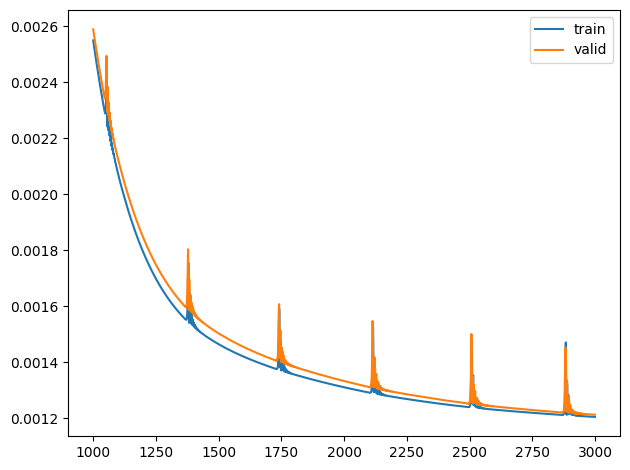

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
start_step = 1000
ax.plot(range(start_step, nsteps), train_loss_history[start_step:nsteps], label = "train")
ax.plot(range(start_step, nsteps), valid_loss_history[start_step:nsteps], label = "valid")
# ax.plot(range(start_step, nsteps), test_loss_history[start_step:nsteps], label = "test")
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [53]:
print(jnp.acos(output[0][0]) * 180 / jnp.pi)
print(-jnp.log(output[0][1]))
print(-jnp.log(output[0][2]))

104.87102416550998
0.9730443712818039
0.9571661232846679


In [54]:
print(u)

[-2.00297511e-02  2.64730904e+01]


In [55]:
from h2o.h2opes_analytic import water_pes
r_exact = 0.95
t_exact = 104.5 * jnp.pi / 180
theta = jnp.arange(jnp.pi/3, jnp.pi, 0.01)
bond = jnp.arange(0.8, 1.2, 0.005)
angle_vary = jnp.array([[r_exact, r_exact, t] for t in theta])
bond_vary = jnp.array([[r, r, t_exact] for r in bond])
batched_pes = jax.vmap(water_pes)
pes_angle_exact = batched_pes(angle_vary) / 1e4
pes_bond_exact = batched_pes(bond_vary) / 1e4

In [56]:
get_input = lambda x: jnp.array([jnp.cos(x[2]), jnp.exp(-x[0]), jnp.exp(-x[1])])
batched_input = jax.vmap(get_input)
angle_input = batched_input(angle_vary)
bond_input = batched_input(bond_vary)
angle_tau = flow_forward(params, angle_input)
bond_tau = flow_forward(params, bond_input)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
batched_pot = jax.vmap(transformed_pes)
pes_angle_reg = batched_pot(angle_tau)
pes_bond_reg = batched_pot(bond_tau)

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_4507/3375021634.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_.show()


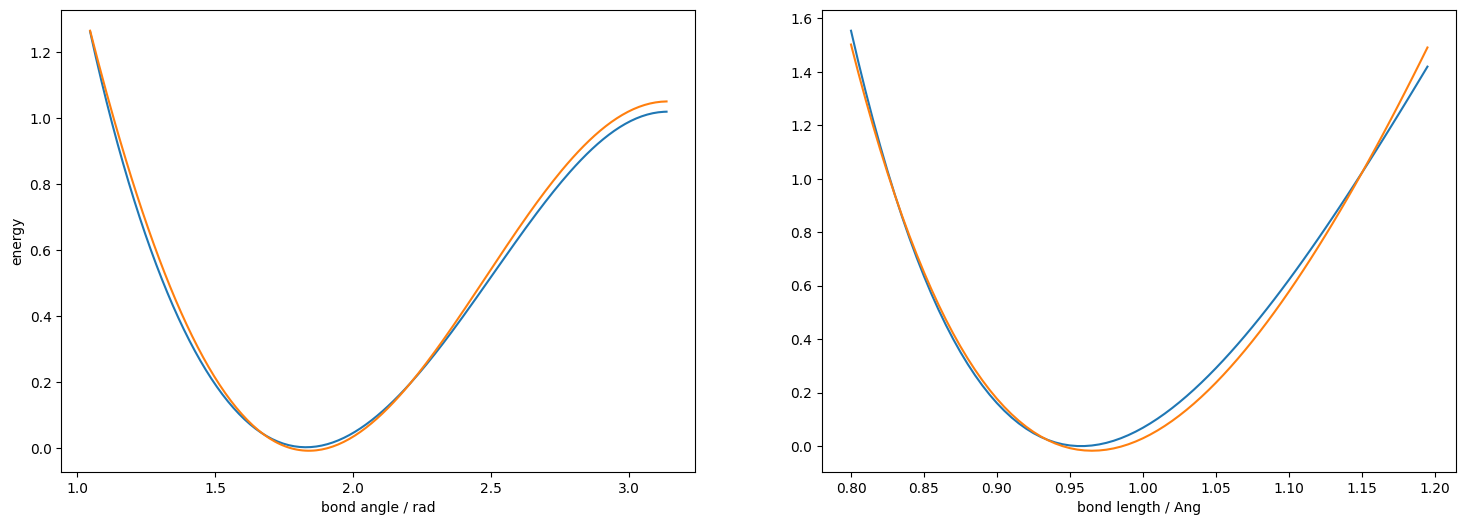

In [57]:
fig_ = plt.figure(figsize=(18, 6))
ax_ = fig_.subplots(1, 2)
ax_[0].plot(theta, pes_angle_exact)
ax_[0].plot(theta, pes_angle_reg)
ax_[0].set_xlabel("bond angle / rad")
ax_[0].set_ylabel("energy")
ax_[1].plot(bond, pes_bond_exact)
ax_[1].plot(bond, pes_bond_reg)
ax_[1].set_xlabel("bond length / Ang")
fig_.show()